In [1]:
# Test example

In [1]:
import pywt
import cv2
cA, cD = pywt.dwt([1, 2, 3, 4], 'db1')

/work/pi_dhruveshpate_umass_edu/aamballa_umass_edu/.conda/envs/Diffusion/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [34]:
import torch
import cv2

In [11]:
original.min(), original.max()

(0.0, 1.0)

In [25]:
HL.shape[0]*2

516

In [27]:
HL1 = torch.nn.functional.interpolate(torch.from_numpy(HL).unsqueeze(0).unsqueeze(0), size = (516,516))

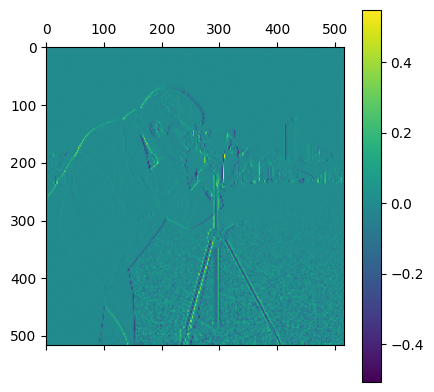

In [36]:
HL1 = cv2.resize(HL, (516,516))
plt.matshow(HL1)
plt.colorbar()

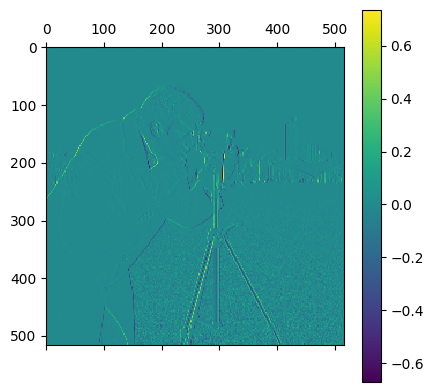

In [33]:
plt.matshow(HL1.numpy()[0][0])
plt.colorbar()

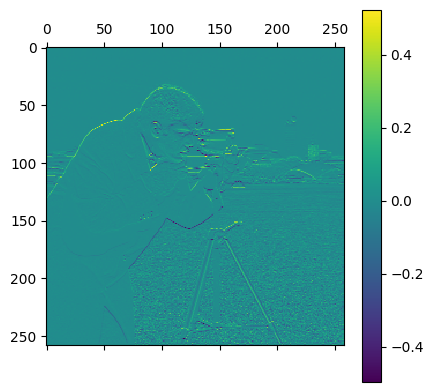

In [19]:
plt.matshow(LH)
plt.colorbar()

(258, 258)


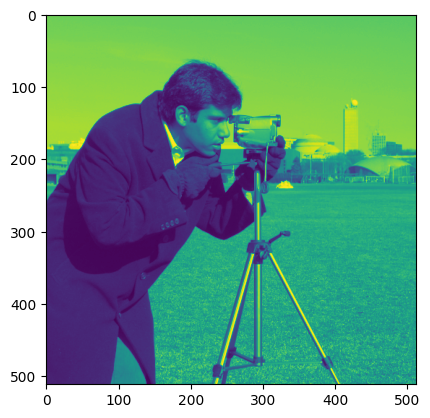

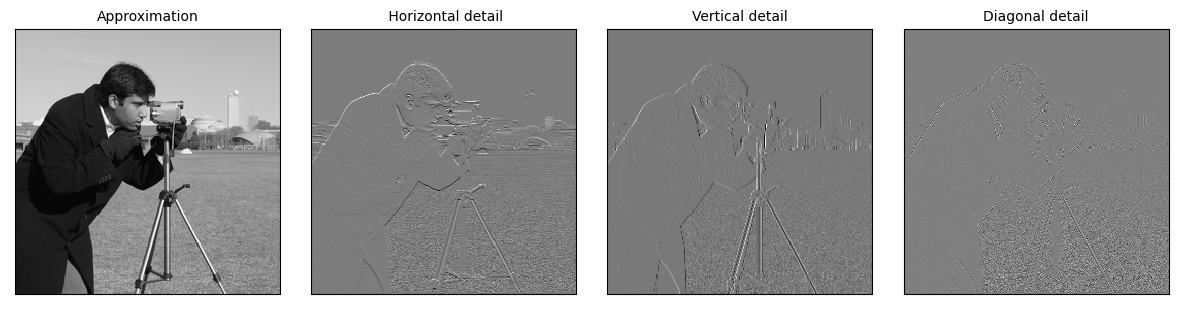

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import pywt
import pywt.data

# Load image
original = pywt.data.camera()/255.0

plt.imshow(original)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2

print(LL.shape)  # half the shape 
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [21]:
# Haar basis wavelet (used in Light VAE) on CIFAR

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import torchvision
import torch
import torchvision.transforms as transforms

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)


Files already downloaded and verified


(32, 32, 3)


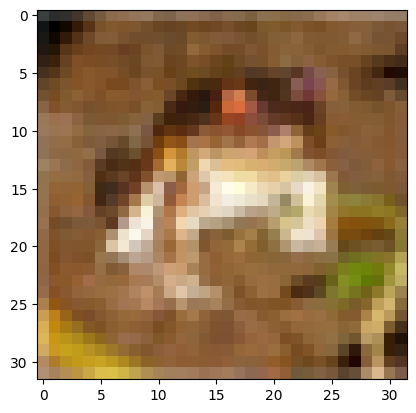

In [5]:
# Get a single image from CIFAR-10 (batch_size=1)
data_iter = iter(trainloader)
images, labels = next(data_iter)
image = images[0].numpy().transpose(1, 2, 0)  # Extract the image (Tensor to numpy array)
print(image.shape)
plt.imshow(image)

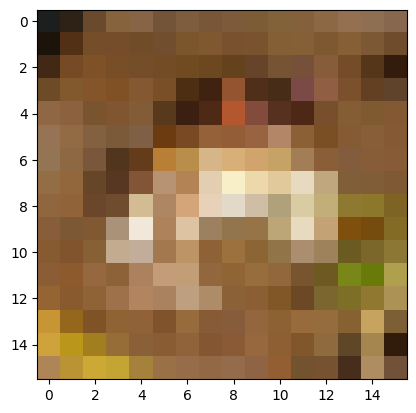

In [6]:
downsampled_image1 = cv2.resize(image, (16,16), interpolation=cv2.INTER_LINEAR)
plt.imshow(downsampled_image1)

In [7]:
# CIFAR-10 image is 3-channel (RGB), apply wavelet transform to each channel separately
def apply_wavelet(img_channel, wavelet='haar'):
    # Apply 2D Discrete Wavelet Transform (DWT) to each channel
    coeffs2 = pywt.dwt2(img_channel, wavelet)
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH, coeffs2

# Apply inverse wavelet transform
def inverse_wavelet(coeffs2, wavelet='haar'):
    return pywt.idwt2(coeffs2, wavelet)


In [8]:
# Upscale the high-frequency components (LH, HL, HH)
def upscale_components(LH, HL, HH, scale=2):
    # Use OpenCV to resize the detail coefficients (high-frequency components)
    # replace with original
    LH_upscaled = cv2.resize(LH, (LH.shape[1] * scale, LH.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    HL_upscaled = cv2.resize(HL, (HL.shape[1] * scale, HL.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    HH_upscaled = cv2.resize(HH, (HH.shape[1] * scale, HH.shape[0] * scale), interpolation=cv2.INTER_LINEAR)
    return LH_upscaled, HL_upscaled, HH_upscaled


# Apply wavelet transform to all three channels of the CIFAR image
channels = ['Red', 'Green', 'Blue']
wavelet = 'haar'  # Haar basis for wavelet decomposition


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


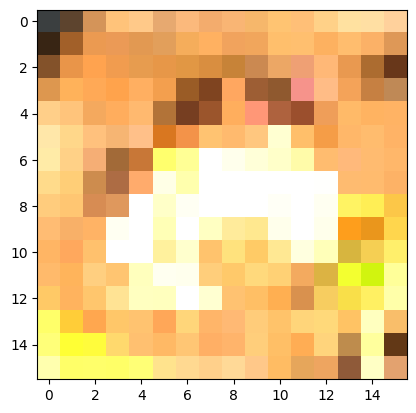

In [9]:
downsampled_image2 = []
for i, channel in enumerate(channels):
    LL, LH, HL, HH, coeffs2 = apply_wavelet(image[:,:, i], wavelet)
    downsampled_image2.append(LL)
downsampled_image2 = np.array(downsampled_image2)
downsampled_image2 = downsampled_image2.transpose(1, 2, 0) 
plt.imshow(downsampled_image2)


In [10]:
def scaled_wavelet(downsampled_image):
    coeffs = {}
    upscaled_coeffs = {}
    
    for i, channel in enumerate(channels):
        LL, LH, HL, HH, coeffs2 = apply_wavelet(downsampled_image[:,:, i], wavelet)
        coeffs[channel] = (LL, LH, HL, HH, coeffs2)
            
        # Upscale high-frequency components
        LH_upscaled, HL_upscaled, HH_upscaled = upscale_components(LH, HL, HH, scale=2)
        
        # Store upscaled coefficients
        upscaled_coeffs[channel] = (downsampled_image[:,:, i], (LH_upscaled, HL_upscaled, HH_upscaled))
    
    
    # Perform inverse wavelet transform with the upscaled high-frequency components
    reconstructed_image = np.zeros((2*downsampled_image.shape[0], 2*downsampled_image.shape[1], 3))
    for i, channel in enumerate(channels):
        reconstructed_image[:, :, i] = inverse_wavelet(upscaled_coeffs[channel], wavelet)
    
    # Display the original and reconstructed images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # Original image
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(reconstructed_image.clip(0, 1))  # Reconstructed image
    ax[1].set_title("Scaled Reconstructed Image (After Inverse DWT)")
    ax[1].axis('off')

    print("L2 norm between original and inverse DWT image {}".format(np.linalg.norm(image-reconstructed_image)))
    plt.show()


L2 norm between original and inverse DWT image 12.94803347313634


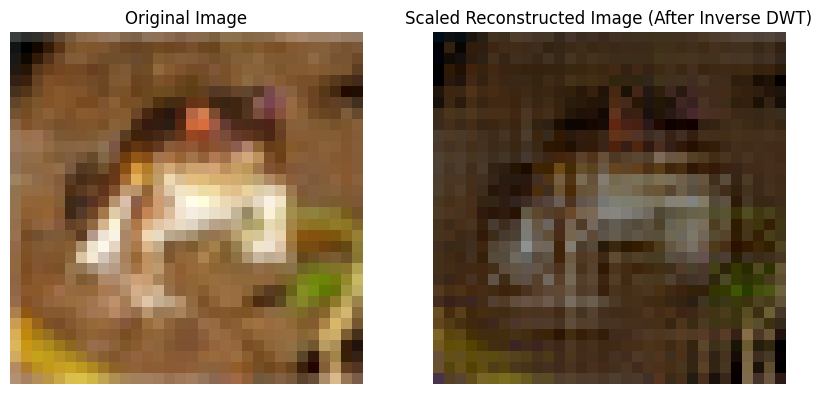

In [11]:
scaled_wavelet(downsampled_image1)

L2 norm between original and inverse DWT image 5.440154289080324


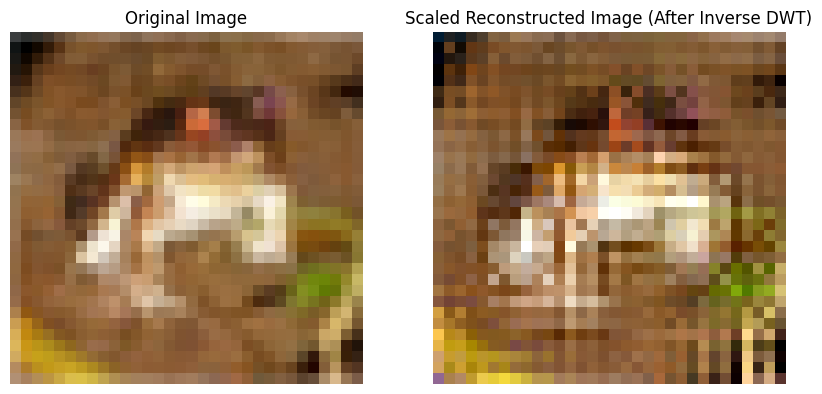

In [12]:
scaled_wavelet(downsampled_image2)

In [13]:
reconstructed_image.shape

(32, 32, 3)